In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import optim
from torchvision import models
from torchvision.utils import make_grid, save_image

from gan import CycleGANConfig, ConvGenerator, ConvDiscriminator, get_cycle_gan_trainer
from __datasets__ import ITSDataset, DenseHazeCVPR2019Dataset
from utils.datasets import DomainDataset
from utils.benchmark import PerceptualLoss, train, test
from utils.display import display_images
from utils.checkpoints import save_checkpoint, load_checkpoint

In [3]:
config1 = CycleGANConfig(
    "../../pytorch/datasets/its",
    "HazeMaze",
    "v1",
    image_shape=(3, 128, 128),
    latent_dim=64,
    dropout=0, n=0,
    num_epochs=1, batch_size=8,
    lr=2e-4,
    betas=(0.5, 0.999),
    lambdas=(10, 0.5),
    residuals=5,
    blocks=(64, 128, 256, 512),
    writer=True,
)
config2 = config1.copy(
    dataset_path="../../pytorch/datasets/dense-haze-cvpr-2019",
    image_shape=(3, 256, 256),
    writer=False,
)

In [4]:
ds1 = DomainDataset(
    ITSDataset(config1.dataset_path, SET="hazy", download=True, image_transform=config1.transforms, sub_sample=1),
    ITSDataset(config1.dataset_path, SET="clear", download=True, image_transform=config1.transforms, sub_sample=1)
)
ds2 = DomainDataset(
    DenseHazeCVPR2019Dataset(config2.dataset_path, SET="hazy", download=True, image_transform=config2.transforms, sub_sample=1),
    DenseHazeCVPR2019Dataset(config2.dataset_path, SET="GT", download=True, image_transform=config2.transforms, sub_sample=1)
)

In [13]:
generatorA = ConvGenerator(
    inp_features=config1.image_shape[0], out_features=config1.image_shape[0],
    latent_features=config1.latent_dim,
    n=config1.n, p=config1.dropout, norm=2,
    residuals=config1.residuals,
).to(config1.device)
generatorB = ConvGenerator(
    inp_features=config1.image_shape[0], out_features=config1.image_shape[0],
    latent_features=config1.latent_dim,
    n=config1.n, p=config1.dropout, norm=2,
    residuals=config1.residuals,
).to(config1.device)
discriminatorA = ConvDiscriminator(
    inp_features=config1.image_shape[0], blocks=config1.blocks,
    n=config1.n, p=config1.dropout, norm=2,
).to(config1.device)
discriminatorB = ConvDiscriminator(
    inp_features=config1.image_shape[0], blocks=config1.blocks,
    n=config1.n, p=config1.dropout, norm=2,
).to(config1.device)

In [14]:
perceptual_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:29].eval().to(config1.device)
perceptual_loss = PerceptualLoss(perceptual_model)
optimizerG = optim.Adam(
    list(generatorA.parameters()) + list(generatorB.parameters()),
    lr=config1.lr, betas=config1.betas,
)
optimizerD = optim.Adam(
    list(discriminatorA.parameters()) + list(discriminatorB.parameters()),
    lr=config1.lr, betas=config1.betas,
)
step_offset = 0

In [7]:
if input("Load Model? [y/n] ").lower() == "y":
    path = input("Path: ")
    others = load_checkpoint(
        path,
        {"generatorA": generatorA, "generatorB": generatorB, "discriminatorA": discriminatorA, "discriminatorB": discriminatorB},
        {"optimizerG": optimizerG, "optimizerD": optimizerD},
        device=config1.device,
    )
    step_offset = others["step"]

In [15]:
fixedA, fixedB = ds1[:9].values()
fixedA, fixedB = fixedA["image"], fixedB["image"]
trainer = get_cycle_gan_trainer(
    generatorA, generatorB, discriminatorA, discriminatorB,
    optimizerG, optimizerD,
    save_path=config1.checkpoint_path, save_period=200,
    perceptual_loss=perceptual_loss,
    lambda_cycle=config1.lambdas[0], lambda_identity=config1.lambdas[1],
    writer=config1.writer, writer_period=100,
    fixedA=fixedA, fixedB=fixedB,
)

In [22]:
generatorA = generatorA.train()
generatorB = generatorB.train()
discriminatorA = discriminatorA.train()
discriminatorB = discriminatorB.train()
step_offset = train(
    trainer,
    ds1, ne=1, bs=config1.batch_size,
    step_offset=step_offset,
)

Epoch: 0/1 | Batch 0/1749|          |  0% [00:00<?, ?it/s , loss=?]


KeyboardInterrupt



In [ ]:
generatorA = generatorA.eval()
generatorB = generatorB.eval()
discriminatorA = discriminatorA.eval()
discriminatorB = discriminatorB.eval()
test

In [ ]:
save_checkpoint(
    config1.checkpoint_path + "checkpoint.pt",
    {"generatorA": generatorA, "generatorB": generatorB, "discriminatorA": discriminatorA, "discriminatorB": discriminatorB},
    {"optimizerG": optimizerG, "optimizerD": optimizerD},
    step=step_offset,
)

In [19]:
_, fixedB = ds2[:24].values()
fixedB = fixedB["image"]
generatorA = generatorA.eval()
with torch.inference_mode():
    print(fixedB.shape)
    %timeit generatorA(fixedB)

torch.Size([24, 3, 256, 256])
1.38 s ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


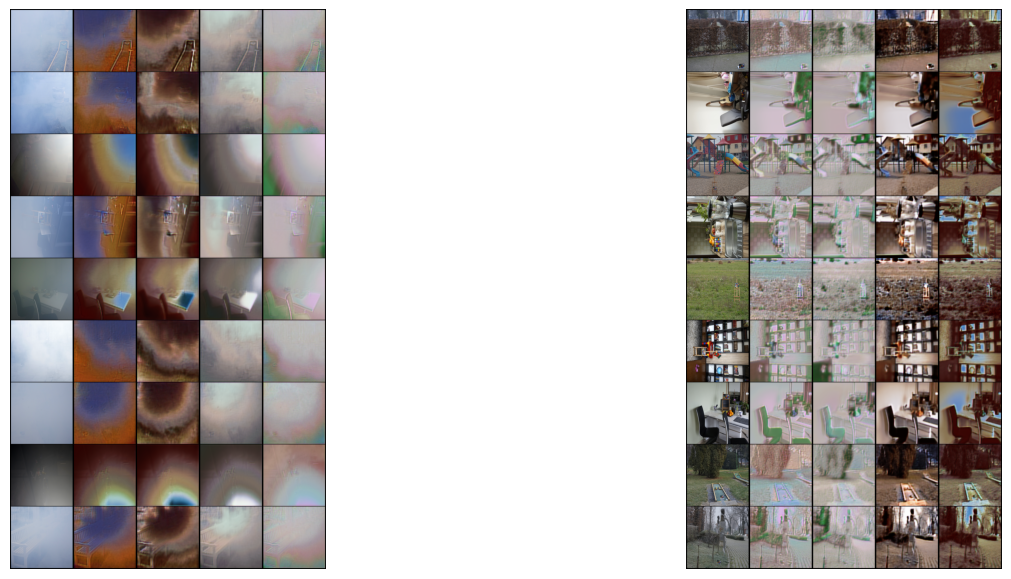

CPU times: user 2.56 s, sys: 1.79 s, total: 4.35 s
Wall time: 7.34 s


In [21]:
%%time

generatorA = generatorA.eval()
generatorB = generatorB.eval()
fixedA, fixedB = ds2[:9].values()
fixedA, fixedB = fixedA["image"], fixedB["image"]
with torch.inference_mode():
    grid_realA = make_grid(fixedA, nrow=1, normalize=True)
    grid_realB = make_grid(fixedB, nrow=1, normalize=True)
    grid_fakeA = make_grid(fakeA := generatorA(fixedB), nrow=1, normalize=True)
    grid_fakeB = make_grid(fakeB := generatorB(fixedA), nrow=1, normalize=True)
    grid_doubleA = make_grid(generatorA(fakeA), nrow=1, normalize=True)
    grid_doubleB = make_grid(generatorB(fakeB), nrow=1, normalize=True)
    grid_cycleA = make_grid(generatorA(fakeB), nrow=1, normalize=True)
    grid_cycleB = make_grid(generatorB(fakeA), nrow=1, normalize=True)
    grid_identityA = make_grid(identityA := generatorA(fixedA), nrow=1, normalize=True)
    grid_identityB = make_grid(identityB := generatorB(fixedB), nrow=1, normalize=True)
    gridA = make_grid(torch.stack([grid_realA, grid_fakeB, grid_doubleB, grid_cycleA, grid_identityA]), nrow=5, normalize=True)
    gridB = make_grid(torch.stack([grid_realB, grid_fakeA, grid_doubleA, grid_cycleB, grid_identityB]), nrow=5, normalize=True)
display_images(torch.stack([gridA, gridB]).permute(0, 2, 3, 1).cpu())

In [ ]:
save_image(gridA, "gridA.png"), save_image(gridB, "gridB.png")